# Analisis sentimen game genshin impact pada berdasarkan review playstore

In [239]:
#import semua library yang dibutuhkan

import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Pastikan stopwords bahasa Indonesia tersedia
from nltk.corpus import stopwords
import nltk

#kebutuhan fetching kamus sentimen dari github
import csv
import requests
from io import StringIO

#visualisasi
import matplotlib.pyplot as plt

#persiapan analisis
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

#lib model
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

In [240]:
# Load dataset
file_path = "review_game_genshin.csv"  # Path ke file CSV yang berisi data ulasan aplikasi
app_reviews_df = pd.read_csv(file_path)

# Menampilkan lima baris pertama dari DataFrame app_reviews_df
app_reviews_df.head()

,userName,content,score,reviewCreatedVersion,at,appVersion
0,Pengguna Google,"Visual cukup memanjakan mata, salah satu game ...",5,5.4.0_30057195_30231699,2025-02-12 07:39:48,5.4.0_30057195_30231699
1,Pengguna Google,Segi Quest Oke Tapi Pas Main agak Frame Drop k...,5,5.5.0_31400259_31451966,2025-04-07 17:44:48,5.5.0_31400259_31451966
2,Pengguna Google,Untuk sejauh ini sudah beragam serta adanya 7 ...,3,5.5.0_31400259_31451966,2025-04-07 22:59:33,5.5.0_31400259_31451966
3,Pengguna Google,"bagus cuman menurut ku quest nya bosenin, dan ...",4,5.5.0_31400259_31451966,2025-04-08 06:52:29,5.5.0_31400259_31451966
4,Pengguna Google,Beberapa teman mengalami cutscene patah-patah ...,5,5.5.0_31400259_31451966,2025-04-08 14:19:24,5.5.0_31400259_31451966


In [241]:
# Menampilkan informasi tentang DataFrame app_reviews_df
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              40000 non-null  object
 1   content               40000 non-null  object
 2   score                 40000 non-null  int64 
 3   reviewCreatedVersion  27133 non-null  object
 4   at                    40000 non-null  object
 5   appVersion            27133 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.8+ MB


In [242]:
# Membuat DataFrame baru (clean_df) dengan menghapus baris yang memiliki nilai yang hilang
clean_df = app_reviews_df.dropna()

# Menghapus baris duplikat dari DataFrame clean_df
clean_df = clean_df.drop_duplicates()
 
# Menghitung jumlah baris dan kolom dalam DataFrame clean_df setelah menghapus duplikat
jumlah_ulasan_setelah_hapus_duplikat, jumlah_kolom_setelah_hapus_duplikat = clean_df.shape

#cek jumlah baris dan kolom setelah menghapus duplikat
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27133 entries, 0 to 39999
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              27133 non-null  object
 1   content               27133 non-null  object
 2   score                 27133 non-null  int64 
 3   reviewCreatedVersion  27133 non-null  object
 4   at                    27133 non-null  object
 5   appVersion            27133 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.4+ MB


In [243]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s!?]', '', text) # menghapus karakter selain huruf dan angka
 
    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    # text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text
 
def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text
 
def tokenizingText(text):
    try:
        return word_tokenize(text)
    except Exception as e:
        print(f"Error in tokenizingText: {e}")
        return []
 
def filteringText(text): # Menghapus stopwords dalam teks
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text
 
def stemmingText(text): # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
 
    # Memecah teks menjadi daftar kata
    words = text.split()
 
    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]
 
    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)
 
    return stemmed_text
 
def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

slangwords = {"yg": "yang", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "gk": "tidak", "gitu": "begitu", "bkn": "bukan", "klo": "kalau", "kya": "seperti", "kpn": "kapan", "kmn": "kemana", "kmu": "kamu", "sama": "dengan", "aja": "saja", "nih": "ini", "lah": "tapi", "ku": "aku", "lo": "kamu", "lu": "kamu", "btw": "ngomong-ngomong", "udh": "sudah", "tdk": "tidak", "dr": "dari", 
    "jd": "jadi", "tp": "tapi", "dgn": "dengan", "trs": "terus", 
    "krn": "karena", "sy": "saya", "trs": "terus", "sbnrnya": "sebenarnya"}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []
 
    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)
 
    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [244]:
try:
    _ = stopwords.words('indonesian')
except LookupError:
    nltk.download('stopwords')

# Pipeline preprocessing teks
# Clean the text and store it in the 'text_clean' column
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)

# Convert text to lowercase and store it in 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

# Replace slang words with standard words and store in 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

# Tokenize the text and store it in 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

# Remove stopwords and store the result in 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# Combine tokens into sentences and store in 'text_akhir'
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

#menampilkan hasil cleaning
clean_df

,userName,content,score,reviewCreatedVersion,at,appVersion,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,Pengguna Google,"Visual cukup memanjakan mata, salah satu game ...",5,5.4.0_30057195_30231699,2025-02-12 07:39:48,5.4.0_30057195_30231699,Visual cukup memanjakan mata salah satu game o...,visual cukup memanjakan mata salah satu game o...,visual cukup memanjakan mata salah satu game o...,"[visual, cukup, memanjakan, mata, salah, satu,...","[visual, memanjakan, mata, salah, game, open, ...",visual memanjakan mata salah game open world p...
1,Pengguna Google,Segi Quest Oke Tapi Pas Main agak Frame Drop k...,5,5.5.0_31400259_31451966,2025-04-07 17:44:48,5.5.0_31400259_31451966,Segi Quest Oke Tapi Pas Main agak Frame Drop k...,segi quest oke tapi pas main agak frame drop k...,segi quest oke tapi pas main agak frame drop k...,"[segi, quest, oke, tapi, pas, main, agak, fram...","[segi, quest, oke, pas, main, frame, drop, set...",segi quest oke pas main frame drop settingan g...
2,Pengguna Google,Untuk sejauh ini sudah beragam serta adanya 7 ...,3,5.5.0_31400259_31451966,2025-04-07 22:59:33,5.5.0_31400259_31451966,Untuk sejauh ini sudah beragam serta adanya e...,untuk sejauh ini sudah beragam serta adanya e...,untuk sejauh ini sudah beragam serta adanya el...,"[untuk, sejauh, ini, sudah, beragam, serta, ad...","[beragam, elemen, berbeda, beragam, team, part...",beragam elemen berbeda beragam team party elem...
3,Pengguna Google,"bagus cuman menurut ku quest nya bosenin, dan ...",4,5.5.0_31400259_31451966,2025-04-08 06:52:29,5.5.0_31400259_31451966,bagus cuman menurut ku quest nya bosenin dan j...,bagus cuman menurut ku quest nya bosenin dan j...,bagus cuman menurut aku quest nya bosenin dan ...,"[bagus, cuman, menurut, aku, quest, nya, bosen...","[bagus, cuman, quest, bosenin, quest, cerita, ...",bagus cuman quest bosenin quest cerita primo d...
4,Pengguna Google,Beberapa teman mengalami cutscene patah-patah ...,5,5.5.0_31400259_31451966,2025-04-08 14:19:24,5.5.0_31400259_31451966,Beberapa teman mengalami cutscene patahpatah s...,beberapa teman mengalami cutscene patahpatah s...,beberapa teman mengalami cutscene patahpatah s...,"[beberapa, teman, mengalami, cutscene, patahpa...","[teman, mengalami, cutscene, patahpatah, memai...",teman mengalami cutscene patahpatah memainkan ...
...,...,...,...,...,...,...,...,...,...,...,...,...
39990,Pengguna Google,Ok walaupun lama ngunduh 10 gb tapi game nya s...,5,2.0.0_3513686_3617618,2021-07-23 02:11:36,2.0.0_3513686_3617618,Ok walaupun lama ngunduh gb tapi game nya seru٩۶,ok walaupun lama ngunduh gb tapi game nya seru٩۶,ok walaupun lama ngunduh gb tapi game nya seru٩۶,"[ok, walaupun, lama, ngunduh, gb, tapi, game, ...","[ok, ngunduh, gb, game, seru٩۶]",ok ngunduh gb game seru٩۶
39991,Pengguna Google,Mantep gan wlpun boros batre ama bikin panas :'),5,1.0.0_1112729_1135452,2020-10-23 22:54:37,1.0.0_1112729_1135452,Mantep gan wlpun boros batre ama bikin panas,mantep gan wlpun boros batre ama bikin panas,mantep gan wlpun boros batre ama bikin panas,"[mantep, gan, wlpun, boros, batre, ama, bikin,...","[mantep, gan, wlpun, boros, batre, ama, bikin,...",mantep gan wlpun boros batre ama bikin panas
39994,Pengguna Google,Rekomendasi spek: Snap 712 Adreno 642 Dan Batr...,5,1.0.0_1112729_1135452,2020-10-06 12:39:14,1.0.0_1112729_1135452,Rekomendasi spek Snap Adreno Dan Batre minim...,rekomendasi spek snap adreno dan batre minim...,rekomendasi spek snap adreno dan batre minimal...,"[rekomendasi, spek, snap, adreno, dan, batre, ...","[rekomendasi, spek, snap, adreno, batre, minim...",rekomendasi spek snap adreno batre minimal mah
39995,Pengguna Google,"Mantap kali mihoyo, game buatan anda selalu me...",5,1.0.0_1112729_1135452,2020-10-01 19:44:02,1.0.0_1112729_1135452,Mantap kali mihoyo game buatan anda selalu mem...,mantap kali mihoyo game buatan anda selalu mem...,mantap kali mihoyo game buatan anda selalu mem...,"[mantap, kali, mihoyo, game, buatan, and

In [245]:
# Fungsi untuk mengambil kamus sentimen dari GitHub
def load_lexicon(url):
    lexicon = {}
    response = requests.get(url)
    
    if response.ok:
        data = StringIO(response.text)
        csv_reader = csv.reader(data)
        for word, score in csv_reader:
            lexicon[word] = int(score)
    else:
        print(f"Gagal memuat data dari: {url}")
    
    return lexicon

# URL kamus sentimen
url_positive = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv'
url_negative = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv'

# Muat kamus positif dan negatif
lexicon_positive = load_lexicon(url_positive)
lexicon_negative = load_lexicon(url_negative)

# Fungsi analisis sentimen berbasis lexicon
def sentiment_analysis_lexicon_indonesia(text):
    score = 0

    for word in text:
        if word in lexicon_positive:
            score += lexicon_positive[word]
        if word in lexicon_negative:
            score += lexicon_negative[word]

    # Menentukan polaritas berdasarkan nilai skor
    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

In [246]:
# Terapkan fungsi analisis sentimen ke kolom 'text_stopword'
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)

# Pisahkan hasil ke dalam dua kolom: skor dan polaritas
clean_df['polarity_score'], clean_df['polarity'] = zip(*results)

# Tampilkan jumlah data berdasarkan polaritas
print(clean_df['polarity'].value_counts())

polarity
negative    12420
positive    11880
neutral      2833
Name: count, dtype: int64


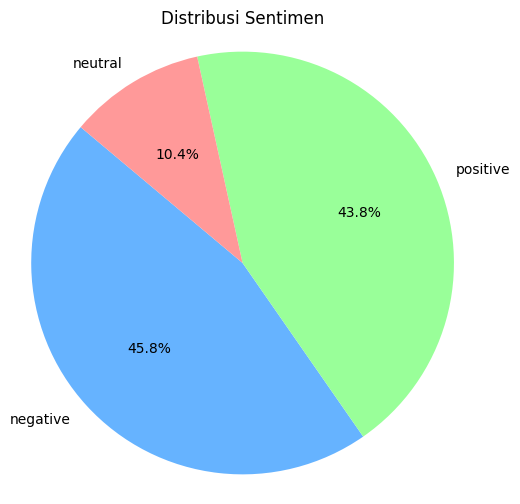

In [247]:
# Hitung jumlah masing-masing sentimen
sentiment_counts = clean_df['polarity'].value_counts()

# Buat pie chart
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#99ff99','#ff9999'])
plt.title('Distribusi Sentimen')
plt.axis('equal')  # Supaya lingkarannya bulat sempurna
plt.show()

In [249]:

# Memisahkan kolom teks dan label sentimen
fitur = clean_df['text_akhir']
label = clean_df['polarity']

# Mengubah teks menjadi representasi numerik dengan TF-IDF
vectorizer = TfidfVectorizer(
    max_features=3000, 
    min_df=7, max_df=0.8, 
    ngram_range=(1,3)
    )
fitur_tfidf = vectorizer.fit_transform(fitur)

# Konversi hasil vektorisasi menjadi DataFrame agar lebih mudah dibaca
df_fitur = pd.DataFrame(fitur_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

# Tampilkan beberapa baris awal dari hasil vektorisasi
print(df_fitur.head())

# Memisahkan data untuk pelatihan dan pengujian model
X_train, X_test, y_train, y_test = train_test_split(fitur_tfidf, label, test_size=0.2, random_state=42)

   abbys  abyss   ad  adain  adain fitur  adakan  adakan fitur  adem  adil  \
0    0.0    0.0  0.0    0.0          0.0     0.0           0.0   0.0   0.0   
1    0.0    0.0  0.0    0.0          0.0     0.0           0.0   0.0   0.0   
2    0.0    0.0  0.0    0.0          0.0     0.0           0.0   0.0   0.0   
3    0.0    0.0  0.0    0.0          0.0     0.0           0.0   0.0   0.0   
4    0.0    0.0  0.0    0.0          0.0     0.0           0.0   0.0   0.0   

   admin  ...  yah  yahh  yak  yapping   yh  yng  youtube   yt  zelda  zhongli  
0    0.0  ...  0.0   0.0  0.0      0.0  0.0  0.0      0.0  0.0    0.0      0.0  
1    0.0  ...  0.0   0.0  0.0      0.0  0.0  0.0      0.0  0.0    0.0      0.0  
2    0.0  ...  0.0   0.0  0.0      0.0  0.0  0.0      0.0  0.0    0.0      0.0  
3    0.0  ...  0.0   0.0  0.0      0.0  0.0  0.0      0.0  0.0    0.0      0.0  
4    0.0  ...  0.0   0.0  0.0      0.0  0.0  0.0      0.0  0.0    0.0      0.0  

[5 rows x 3000 columns]


In [250]:
# Inisialisasi model Support Vector Machine (SVM) dengan kernel linear
svm_model = LinearSVC(
    C=3.2,          # Kamu bisa tuning ini, misal coba 0.1, 0.5, 1, 2
    max_iter=10000,
    random_state=42
)

# Latih model SVM dengan data training
svm_model.fit(X_train.toarray(), y_train)

# Prediksi hasil pada data training dan data testing
y_pred_train_svm = svm_model.predict(X_train.toarray())
y_pred_test_svm = svm_model.predict(X_test.toarray())

# Evaluasi performa model menggunakan akurasi
accuracy_train_svm = accuracy_score(y_pred_train_svm, y_train)
accuracy_test_svm = accuracy_score(y_pred_test_svm, y_test)

# Tampilkan hasil akurasi model SVM
print('SVM - accuracy_train:', accuracy_train_svm)
print('SVM - accuracy_test:', accuracy_test_svm)

SVM - accuracy_train: 0.9226941859393716
SVM - accuracy_test: 0.8581168232909526
